In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# utils
import numpy as np
from typing import List, Tuple, Dict, Optional

import numpy as np

def smooth_labels(
    arr: np.ndarray,
    window_size_samples: int,
    threshold_count: int
) -> np.ndarray:
    """
    Smooth a 1D binary array by counting 1's in a sliding window.

    Parameters
    ----------
    arr : np.ndarray
        1D array of 0/1 labels.
    window_size_samples : int
        Number of samples in the sliding window.
    threshold_count : int
        Minimum number of ones in that window to set center to 1.

    Returns
    -------
    np.ndarray
        Smoothed 1D array of 0/1.
    """
    x = arr.astype(int)
    kernel = np.ones(window_size_samples, dtype=int)
    counts = np.convolve(x, kernel, mode='same')
    return (counts > threshold_count).astype(int)

def get_events(mask: np.ndarray) -> List[Tuple[int,int]]:
    """
    Given a 1D boolean array, return a list of (start, end) indices
    for each run of consecutive True values.
    """
    events = []
    in_event = False
    for i, v in enumerate(mask):
        if v and not in_event:
            start = i
            in_event = True
        elif not v and in_event:
            end = i - 1
            events.append((start, end))
            in_event = False
    if in_event:
        events.append((start, len(mask) - 1))
    return events

def evaluate_event_detection(
    pred: np.ndarray,
    truth: np.ndarray,
    fs: Optional[float] = None
) -> Dict[str, object]:
    """
    Compare predicted and true boolean masks at the event (run) level,
    and compute false-alarm rate if sampling rate fs is given.

    Parameters
    ----------
    pred : np.ndarray
        1D boolean array of predicted anomaly flags.
    truth : np.ndarray
        1D boolean array of ground-truth anomaly flags.
    fs : float, optional
        Sampling rate in Hz; if provided, computes false alarms per hour.

    Returns
    -------
    Dict[str, object]
        {
          'truth_events': List[(start, end)],
          'pred_events' : List[(start, end)],
          'TP_events'   : int,
          'FN_events'   : int,
          'FP_events'   : int,
          'sensitivity' : float,
          'event_iou'   : float,
          'false_alarm_rate_per_hour': float (if fs is not None),
        }
    """
    truth_events = get_events(truth)
    pred_events  = get_events(pred)

    # True Positives: how many true events have any overlap with a prediction
    TP = sum(1 for (ts, te) in truth_events if pred[ts:te+1].any())
    FN = len(truth_events) - TP

    # False Positives: predicted events with no overlap on any true event
    FP = sum(1 for (ps, pe) in pred_events if not truth[ps:pe+1].any())

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    event_iou   = TP / (TP + FN + FP) if (TP + FN + FP) > 0 else 0.0

    metrics: Dict[str, object] = {
        'truth_events': truth_events,
        'pred_events' : pred_events,
        'TP_events'   : TP,
        'FN_events'   : FN,
        'FP_events'   : FP,
        'sensitivity' : sensitivity,
        'event_iou'   : event_iou,
    }

    if fs is not None:
        total_hours = len(truth) / fs / 3600.0
        far_per_hour = FP / total_hours if total_hours > 0 else float('inf')
        metrics['false_alarm_rate_per_hour'] = far_per_hour

    return metrics

def load_pkl(fname: str):
    with open(fname, 'rb') as f:
        result = pickle.load(f)
    return result

### Load $a^*$
= anomaly scores with a specific $\alpha$

In [4]:
# load the pickle resulting data

dataset_index = 1
latent_window_size_rate = 0.5  # "latent_window_size = r_w x latent_window_size", where r_w denotes the latent window size rate; it can be one of {0.1, 0.3, 0.5}

result = load_pkl(os.path.join('results', f'{dataset_index:03}-anomaly_score-latent_window_size_rate_{latent_window_size_rate}.pkl'))

/tmp/ipykernel_699222/102575597.py:117: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  result = pickle.load(f)


In [5]:
result

{'dataset_index': '001',
 'latent_window_size_rate': np.float64(0.5),
 'latent_window_size': 21,
 'rolling_window_stride_rate': 0.1,
 'q': 0.99,
 'X_test_unscaled': tensor([-14.0169,  12.9532,  32.8273,  ..., -41.5660, 101.1364, 162.9164]),
 'Y': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'a_star': array([[2.82130027, 2.82130027, 2.82130027, ..., 3.74543643, 3.74543643,
         3.74543643],
        [2.8976202 , 2.8976202 , 2.8976202 , ..., 3.16050649, 3.16050649,
         3.16050649],
        [1.81005049, 1.81005049, 1.81005049, ..., 2.89695239, 2.89695239,
         2.89695239]], shape=(3, 3069376)),
 'X_recons_test': array([ 8.87120724,  5.84149933, 21.04988861, ..., -0.85342264,
        13.78582382, 43.13564301], shape=(3069376,)),
 'timestep_rng_test': range(0, 3068791, 64),
 'anom_threshold': array([44.51337552, 44.60507011, 37.6412251 ])}

**Details of the stored data keys**
* dataset_index: dataset index
* latent_window_size_rate: latent window size rate, notated as $r_w$
* latent_window_size: latent window size
* rolling_window_stride_rate: determines a stride size (i.e., rolling_window_stride) as a window size $T$ multiplied by rolling_window_stride_rate.
* q: quantile to determine the anomaly score threshold
* X_test_unscaled: a test data (time series) without any scaling
* Y: labels with 0 indicating non-anomaly and 1 indicating anomaly
* a_star: $a^*$
* X_recons_test: a reconstruction of the test time series; to see if the encoder and decoder can compress and decompress the data properly.
* timestep_rng_test: a range of $t$ to produce a window that spans $t$ to $t+T$ to get $x$; the stride size denotes rolling_window_stride.
* anom_threshold: the threshold values for the different frequency bands; the first element corresponds to the lowest frequency band and vice versa.

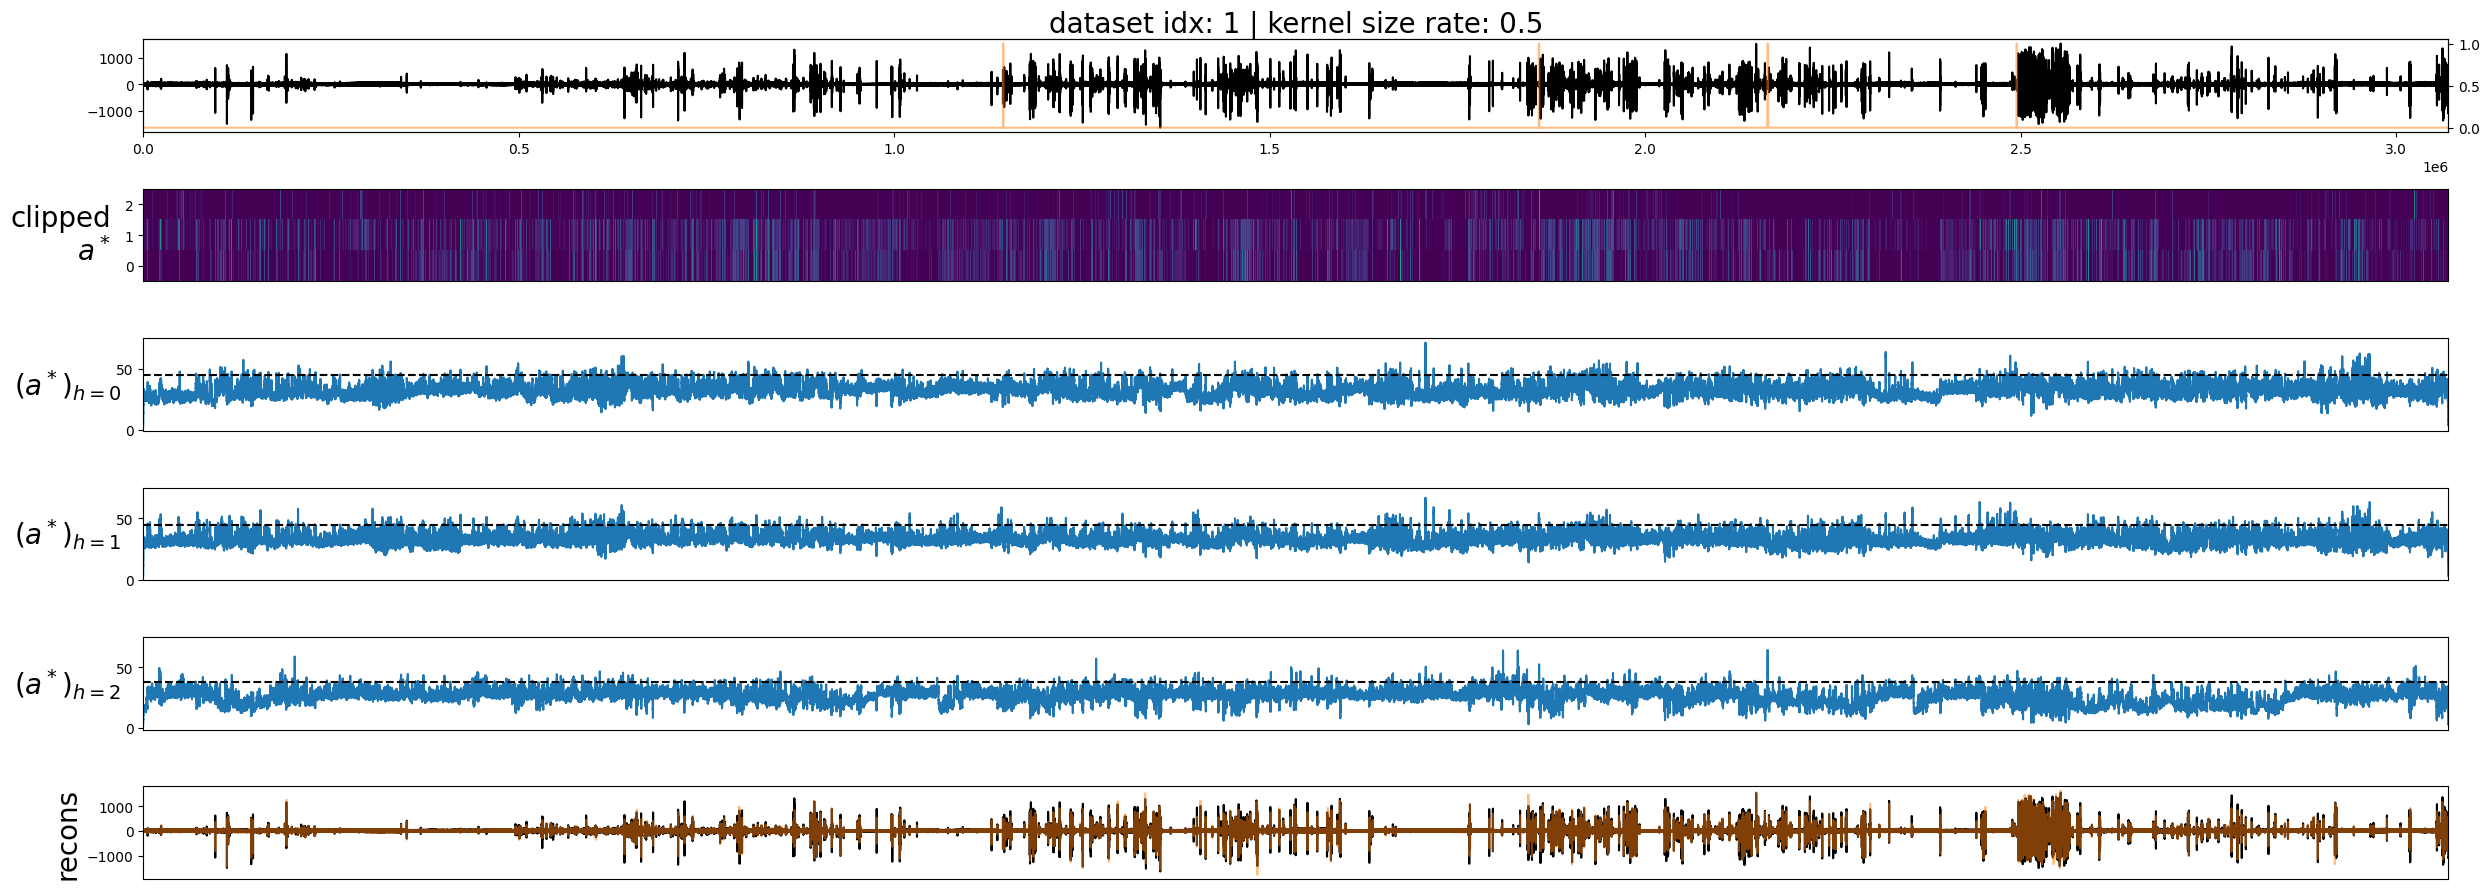

In [6]:
# take out some vars for plotting
X_test_unscaled = result['X_test_unscaled']
Y = result['Y']
a_star = result['a_star']
anom_threshold = result['anom_threshold']
X_recons_test = result['X_recons_test']
kernel_size_rate = 0.5
# plot
n_rows = 6
fig, axes = plt.subplots(n_rows, 1, figsize=(25, 1.5 * n_rows))

# plot: X_test & labels
i = 0
axes[i].plot(X_test_unscaled, color='black')
axes[i].set_xlim(0, X_test_unscaled.shape[0] - 1)
axes[i].set_title(f"dataset idx: {dataset_index} | kernel size rate: {kernel_size_rate}", fontsize=20)
ax2 = axes[i].twinx()
ax2.plot(Y, alpha=0.5, color='C1')

# plot (imshow): anomaly score
i += 1
vmin = np.nanquantile(np.array(a_star).flatten(), q=0.5)  # q to remove the insignificant values in imshow.
axes[i].imshow(a_star, interpolation='nearest', aspect='auto', vmin=vmin)
axes[i].invert_yaxis()
axes[i].set_xticks([])
ylabel = 'clipped\n' + r'$a^*$'
axes[i].set_ylabel(ylabel, fontsize=20, rotation=0, labelpad=10, ha='right', va='center')

ylim_max = np.max(a_star) * 1.05
for j in range(a_star.shape[0]):
    i += 1
    axes[i].plot(a_star[j])
    axes[i].set_xticks([])
    xlim = (0, a_star[j].shape[0] - 1)
    axes[i].set_xlim(*xlim)
    axes[i].set_ylim(None, ylim_max)
    h_idx = f'h={j}'
    axes[i].set_ylabel(r'$(a^*)_{{{}}}$'.format(h_idx),
                       fontsize=20, rotation=0, labelpad=35, va='center')
    threshold = 1e99 if anom_threshold[j] == np.inf else anom_threshold[j]
    axes[i].hlines(threshold, xmin=xlim[0], xmax=xlim[1], linestyle='--', color='black')

# plot: reconstruction
i += 1
axes[i].plot(X_test_unscaled, color='black')
axes[i].plot(X_recons_test, alpha=0.5, color='C1')
axes[i].set_xticks([])
axes[i].set_xlim(0, X_test_unscaled.shape[0] - 1)
axes[i].set_ylabel('recons', fontsize=20)

plt.tight_layout()
plt.show()

### Load $a^*_s$, $\bar{a}_s^*$, $\bar{\bar{a}}_s^*$, $a_\text{final}$
* $a_\text{final}$: final anomaly scores

In [7]:
# load the pickle resulting data

result = load_pkl(os.path.join('results', f'{dataset_index:03}-joint_anomaly_score.pkl'))

/tmp/ipykernel_699222/102575597.py:117: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  result = pickle.load(f)


In [8]:
result

{'dataset_index': '001',
 'X_test_unscaled': tensor([-14.0169,  12.9532,  32.8273,  ..., -41.5660, 101.1364, 162.9164]),
 'Y': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'a_s^*': array([[ 7.3843714 ,  7.3843714 ,  7.3843714 , ..., 11.73499107,
         11.73499107, 11.73499107],
        [ 8.61105967,  8.61105967,  8.61105967, ..., 11.01334023,
         11.01334023, 11.01334023],
        [ 6.45096231,  6.45096231,  6.45096231, ...,  9.07382584,
          9.07382584,  9.07382584]], shape=(3, 3069376)),
 'bar{a}_s^*': array([ 7.48213112,  7.48213112,  7.48213112, ..., 10.60738571,
        10.60738571, 10.60738571], shape=(3069376,)),
 'doublebar{a}_s^*': array([21.27690156, 21.33590206, 21.39453609, ..., 29.56127426,
        29.46702082, 29.37218013], shape=(3069376,)),
 'a_final': array([14.37951634, 14.40901659, 14.43833361, ..., 20.08432999,
        20.03720327, 19.98978292], shape=(3069376,)),
 'joint_threshold': array([148.35109472, 147.64367056, 125.05937791]),
 'final_threshold': np.float6

**Details of the stored data keys**
* a_s^*: $a_s^*$
* bar{a}_s^*: $\bar{a}_s^*$
* doublebar{a}_s^*: $\bar{\bar{a}}_s^*$
* a_final: $a_\text{final}$
* joint_threshold: a summation of `anom_threshold` across different latent_window_size_rate-s
* final_threshold: an average of `joint_threshold` across different frequency bands.

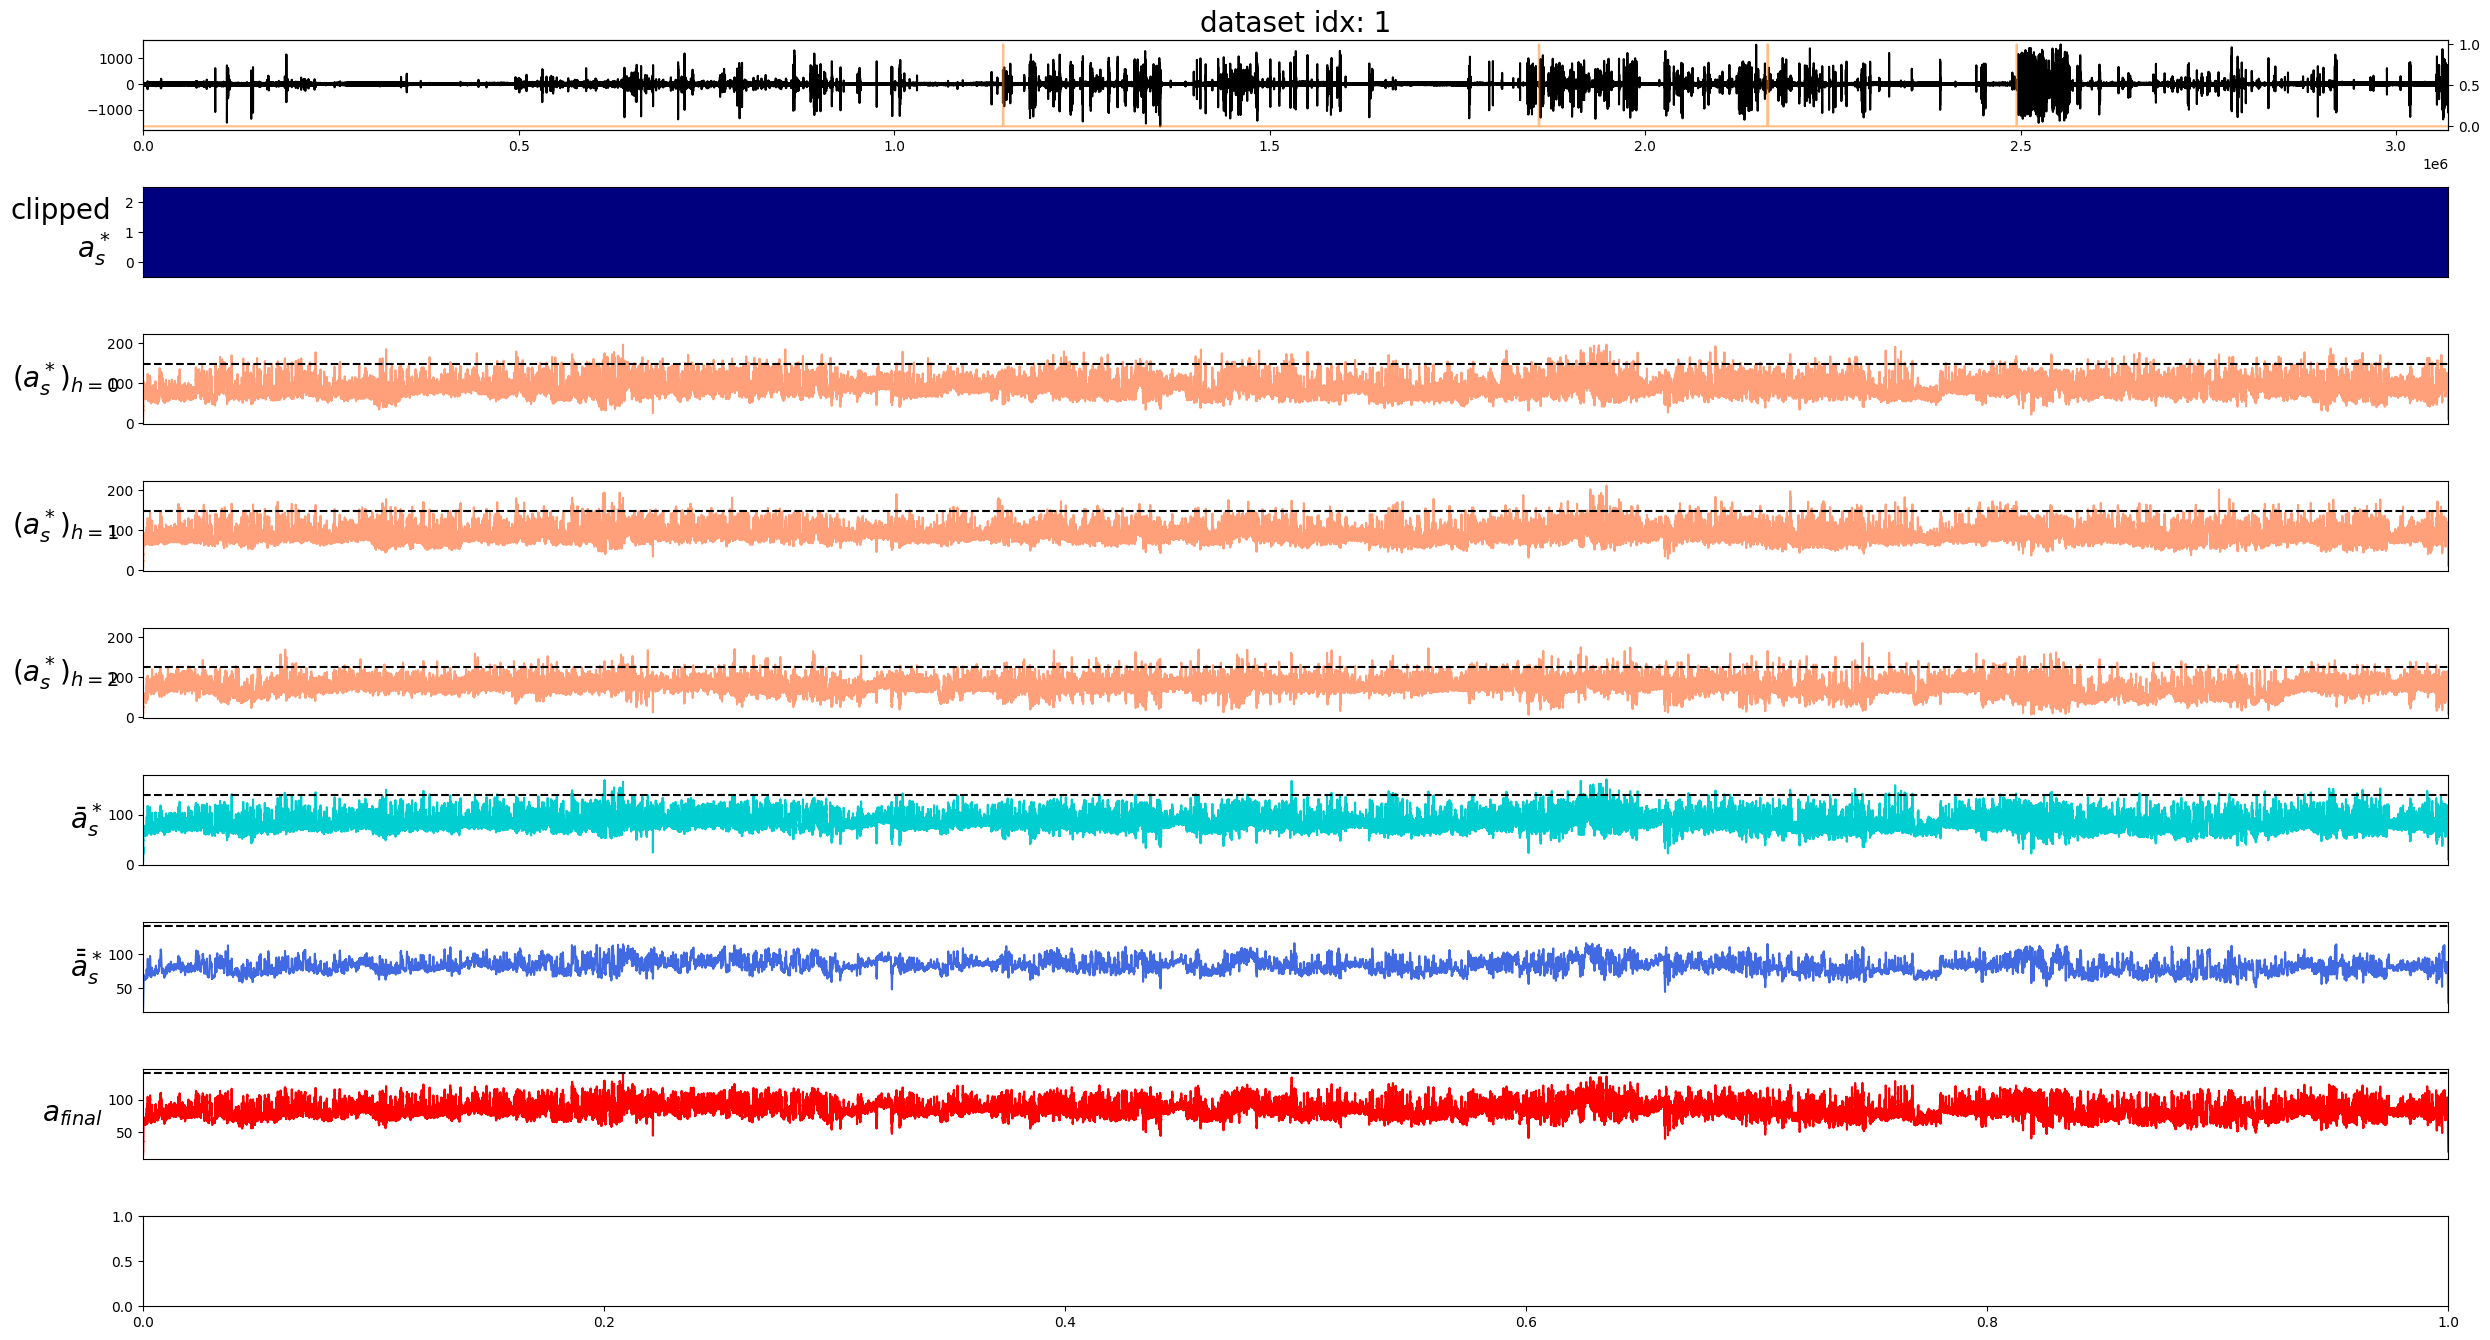

In [9]:
# take out some vars for plotting
a_s_star = result['a_s^*']
a_bar_s_star = result['bar{a}_s^*']
a_2bar_s_star = result['doublebar{a}_s^*']
a_final = result['a_final']
joint_threshold = result['joint_threshold']
final_threshold = result['final_threshold']
X_test_unscaled = result['X_test_unscaled']
# plot
n_rows = 9
fig, axes = plt.subplots(n_rows, 1, figsize=(25, 1.5 * n_rows))

# plot: X_test & labels
i = 0
axes[i].plot(X_test_unscaled, color='black')
axes[i].set_xlim(0, X_test_unscaled.shape[0] - 1)
axes[i].set_title(f"dataset idx: {dataset_index}", fontsize=20)
ax2 = axes[i].twinx()
ax2.plot(Y, alpha=0.5, color='C1')

# plot (imshow): a_s^*
i += 1
anom_ind = a_final > final_threshold
a_s_star_clipped = np.copy(a_s_star)
a_s_star_clipped[:, ~anom_ind] = 0. if anom_ind.mean() == 0 else np.min(a_s_star_clipped[:, anom_ind])
axes[i].imshow(a_s_star_clipped, interpolation='nearest', aspect='auto', cmap='jet')  # , vmin=vmin)
axes[i].invert_yaxis()
axes[i].set_xticks([])
ylabel = 'clipped\n' + r'$a_s^*$'
axes[i].set_ylabel(ylabel, fontsize=20, rotation=0, labelpad=10, ha='right', va='center')

# plot: a_s^*
n_freq = a_s_star.shape[0]
max_anom = a_s_star.max()
for j in range(n_freq):
    i += 1
    axes[i].plot(a_s_star[j], color='lightsalmon')
    axes[i].set_xticks([])
    axes[i].set_xlim(0, a_s_star.shape[1] - 1)
    h_idx = f'h={j}'
    axes[i].set_ylabel(r'$(a_s^*)_{{{}}}$'.format(h_idx), fontsize=20, rotation=0, labelpad=30, va='center')
    axes[i].set_ylim(None, max_anom + 0.05 * max_anom)
    axes[i].hlines(joint_threshold[j], xmin=0, xmax=len(a_s_star[j]) - 1, linestyle='--', color='black')

# plot: bar{a}_s^*
i += 1
axes[i].plot(a_bar_s_star, color='darkturquoise')
axes[i].set_xticks([])
axes[i].set_xlim(0, len(a_bar_s_star) - 1)
axes[i].set_ylabel(r'$\bar{a}_s^*$', fontsize=20, rotation=0, labelpad=15, va='center')
axes[i].hlines(final_threshold, xmin=0, xmax=len(a_bar_s_star) - 1, linestyle='--', color='black')

# plot: doublebar{a}_s^*
i += 1
rng = np.arange(len(a_2bar_s_star))
axes[i].plot(rng, a_2bar_s_star, color='royalblue')
axes[i].set_xticks([])
axes[i].set_xlim(0, len(a_2bar_s_star) - 1)
axes[i].set_ylabel(r'$\bar{\bar{a}}_s^*$', fontsize=20, rotation=0, labelpad=15, va='center')
axes[i].hlines(final_threshold, xmin=0, xmax=len(a_2bar_s_star) - 1, linestyle='--', color='black')

# plot: a_final
i += 1
rng = np.arange(len(a_final))
axes[i].plot(rng, a_final, color='red')
axes[i].set_xticks([])
axes[i].set_xlim(0, len(a_final) - 1)
axes[i].set_ylabel(r'$a_{final}$', fontsize=20, rotation=0, labelpad=25, va='center')
axes[i].hlines(final_threshold, xmin=0, xmax=len(a_final) - 1, linestyle='--', color='black')

plt.tight_layout()
plt.show()

# Custom evaluation

In [10]:
min_threshhold = min(joint_threshold)
min_threshhold

np.float64(125.05937790870667)

In [21]:
np.max(a_final), final_threshold

(np.float64(139.56805201163516), np.float64(140.3513810634613))

In [ ]:
pred_bool = a_s_star[1] > min_threshhold

In [85]:
sum(pred_bool)

np.int64(506400)

In [86]:
pred_Y = pred_bool.astype(int)
truth = Y.bool()

In [91]:
pred =  pred_Y# smooth_labels(pred_Y, 60*8, 50*8)

[(1144880, 1145455),
 (1858328, 1858975),
 (2162608, 2163751),
 (2494632, 2494831)]

In [92]:
# pred and truth are 1D boolean numpy arrays
# fs = your ECG sampling rate (e.g. 8.0 Hz)
metrics = evaluate_event_detection(pred, truth, fs=8.0)

print("True events:", metrics['truth_events'])
print("Predicted events:", metrics['pred_events'])
print(f"TP={metrics['TP_events']}, FN={metrics['FN_events']}, FP={metrics['FP_events']}")
print(f"Sensitivity: {metrics['sensitivity']:.3f}, Event-IoU: {metrics['event_iou']:.3f}")
if 'false_alarm_rate_per_hour' in metrics:
    print(f"False alarms per hour: {metrics['false_alarm_rate_per_hour']:.2f}")

True events: [(1144880, 1145455), (1858328, 1858975), (2162608, 2163751), (2494632, 2494831)]
Predicted events: [(4768, 4783), (5936, 6127), (7344, 7375), (7408, 7423), (9024, 9375), (9392, 9423), (9728, 9743), (11888, 11935), (11952, 11967), (16336, 16351), (16400, 16431), (17024, 17071), (21696, 21743), (21760, 21807), (21856, 21871), (21936, 21951), (22128, 22143), (22656, 22703), (22720, 22735), (22752, 22767), (23216, 24191), (24208, 24223), (24240, 24255), (24304, 24527), (24544, 24559), (24704, 24719), (26992, 27007), (30416, 30431), (32544, 32559), (34608, 34623), (36928, 36975), (36992, 37023), (37040, 37087), (37120, 37151), (39280, 39295), (41552, 41567), (42224, 42239), (42288, 42303), (42512, 42527), (43312, 43327), (44416, 44431), (44784, 44799), (45808, 45823), (46384, 46399), (46416, 46431), (46448, 46511), (46544, 46559), (46928, 46943), (47056, 47071), (47088, 47103), (47120, 47327), (47344, 47359), (48560, 48719), (48736, 48767), (49600, 49615), (49744, 49759), (5132